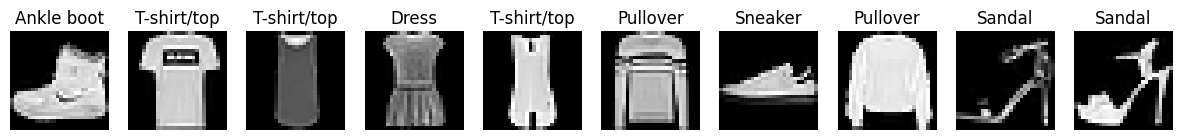

In [36]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

mnist = fetch_openml('fashion-mnist', version=1)
X, y = mnist.data, mnist.target
N = 250

fashion_mnist_labels = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

# Reshape one sample to 28x28 and plot first 10 images
fig, axes = plt.subplots(1, 10, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(X.iloc[i].values.reshape(28, 28), cmap='gray')
    ax.axis('off')
    ax.set_title(fashion_mnist_labels[int(y[i])])

plt.show()
X = [X.iloc[i].values.reshape(28, 28).tolist() for i in range(X.shape[0])]
y = y.tolist()

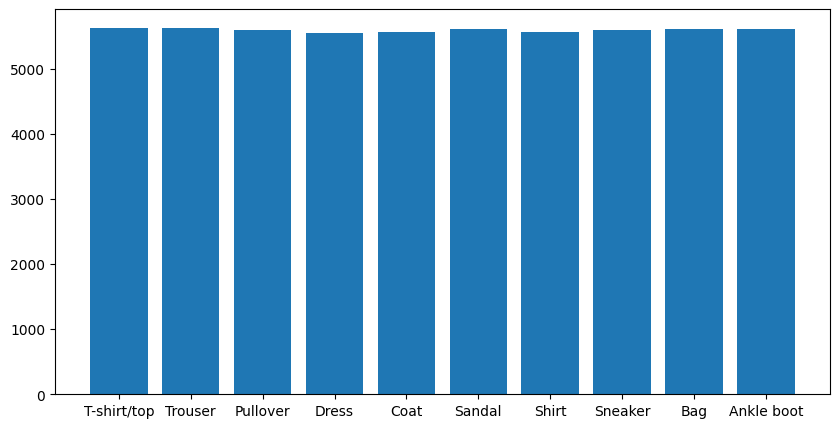

torch.Size([56000, 1, 28, 28])


In [37]:
X = torch.tensor(X, dtype=torch.float32)
X = X/255
X = X.unsqueeze(1)

y = torch.tensor([int(i) for i in y])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

ct = [0 for _ in range(10)]
for i in y_train:
    ct[i] += 1

plt.figure(figsize=(10, 5))
plt.bar(fashion_mnist_labels, ct)
plt.show()
print(X_train.shape)


In [41]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 8, 3)
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(26*26*8, 1028),
            nn.ReLU(),
            nn.Linear(1028, 1028),
            nn.ReLU(),
            nn.Linear(1028, 10),
        )
    
    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = Network().to(device)

print(model)


Using mps device
Network(
  (conv): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=5408, out_features=1028, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1028, out_features=1028, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1028, out_features=10, bias=True)
  )
)


In [42]:
train_dataloader = DataLoader(train_dataset, batch_size=N)
test_dataloader = DataLoader(test_dataset, batch_size=N)

def train(model, dataloader, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()

    for i, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if i % 100 == 0:
            loss, current = loss.item(), i * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(model, dataloader, loss_fn):
    size = len(dataloader.dataset)
    num_N = len(dataloader)
    
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss = loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_N
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [43]:
epochs = 10

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

for i in range(epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    train(model, train_dataloader, loss_fn, optimizer)
    test(model, test_dataloader, loss_fn)

for param_group in optimizer.param_groups:
    param_group['lr'] = 1e-4

for i in range(epochs//2):
    print(f"Fine Epoch {i+1}\n-------------------------------")
    train(model, train_dataloader, loss_fn, optimizer)
    test(model, test_dataloader, loss_fn)

print("Done!")

Epoch 1
-------------------------------
loss: 2.299099  [    0/56000]
loss: 0.469951  [25000/56000]
loss: 0.530296  [50000/56000]
Test Error: 
 Accuracy: 81.4%, Avg loss: 0.008097 

Epoch 2
-------------------------------
loss: 0.440522  [    0/56000]
loss: 0.356675  [25000/56000]
loss: 0.400323  [50000/56000]
Test Error: 
 Accuracy: 85.7%, Avg loss: 0.006319 

Epoch 3
-------------------------------
loss: 0.319842  [    0/56000]
loss: 0.317243  [25000/56000]
loss: 0.372294  [50000/56000]
Test Error: 
 Accuracy: 87.3%, Avg loss: 0.005561 

Epoch 4
-------------------------------
loss: 0.292435  [    0/56000]
loss: 0.261261  [25000/56000]
loss: 0.330096  [50000/56000]
Test Error: 
 Accuracy: 87.4%, Avg loss: 0.005272 

Epoch 5
-------------------------------
loss: 0.281079  [    0/56000]
loss: 0.245467  [25000/56000]
loss: 0.302389  [50000/56000]
Test Error: 
 Accuracy: 88.2%, Avg loss: 0.004965 

Epoch 6
-------------------------------
loss: 0.240300  [    0/56000]
loss: 0.230689  [250

torch.Size([10, 1, 28, 28])


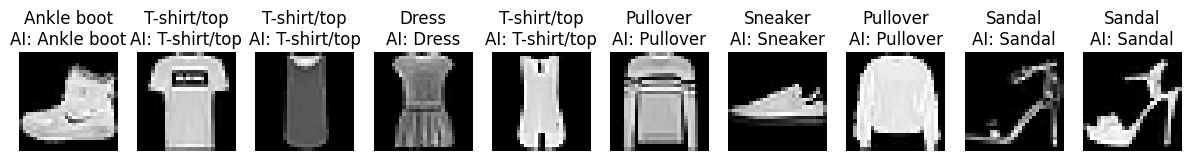

In [ ]:
model.eval()
cut = 0

with torch.no_grad():
    X_eval = X[0+cut:10+cut]
    print(X_eval.shape)
    pred = model(X_eval)
    predictions = pred.argmax(1).tolist()

X[0+cut:10+cut].cpu()
fig, axes = plt.subplots(1, 10, figsize=(15, 3))
for i, ax in enumerate(axes):
    actual_i = i+cut
    ax.imshow(X[actual_i][0], cmap='gray')
    ax.axis('off')
    ax.set_title(f"{fashion_mnist_labels[int(y[actual_i])]}\nAI: {fashion_mnist_labels[predictions[i]]}")

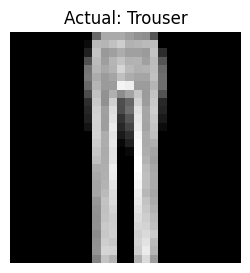

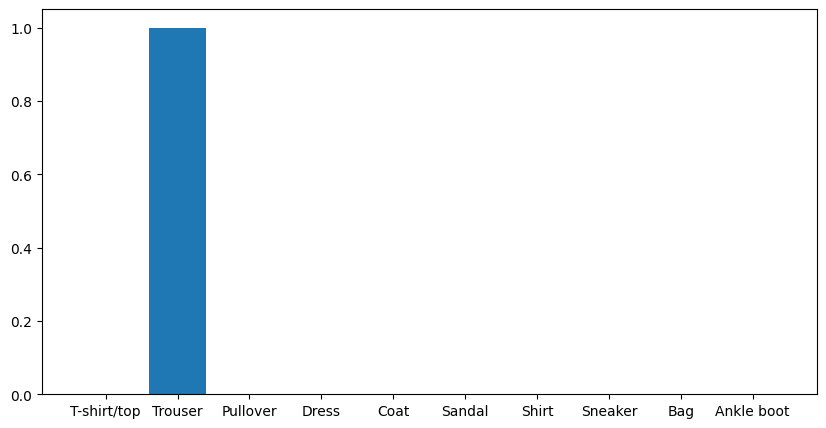

tensor([4.2769e-29, 1.0000e+00, 7.1184e-31, 1.0494e-20, 3.2303e-18, 4.7571e-35,
        4.1050e-18, 3.3713e-31, 4.6851e-23, 2.5557e-34])


In [72]:
model.eval()
subject = 69

with torch.no_grad():
    X_eval = X[subject]
    X_eval = X_eval.unsqueeze(0)
    X_eval = X_eval.to(device)
    pred = model(X_eval)
    
    pred = pred.squeeze(0)
    pred = torch.softmax(pred, dim=0)

X[subject].cpu()
pred = torch.Tensor.cpu(pred)

plt.figure(figsize=(3, 3))
plt.imshow(X[subject].squeeze(0), cmap='gray')
plt.axis('off')
plt.title(f"Actual: {fashion_mnist_labels[int(y[subject])]}")
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(fashion_mnist_labels, pred)
plt.show()

print(pred)